# <center>**Cassava Leaves Disease Detection**</center>

In [32]:
# Import Statements

# Data Configuration and Viz library Imports
import numpy as np  # For numerical operations.
import pandas as pd # For preprocessing and dataframing.
import seaborn as sns # For Data vizualisatons.
import matplotlib.pyplot as plt # For plotting graphs and data Viz.

# Keras Imports
from keras.models import Model, Sequential  # https://keras.io/api/models/model/
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D # https://keras.io/api/layers/
from keras.optimizers import Adam, SGD, RMSprop # https://keras.io/api/optimizers/

# Scikit Learn Imports
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Open CV Import
import cv2 # library of programming functions mainly aimed at real-time computer vision

# Tensorflow library Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Other Imports
from tqdm import tqdm # tqdm module allows for the generation of progress bars in Python.
import os             # For OS related operations and read write operations in the file system.
import json           # For reading the JSON file which store the labels for each indices of the catagory of leaves.
import warnings

In [2]:
warnings.filterwarnings('ignore')

**The above statements are used to import all necessary libraries for various tasks performed in the analysis.**

**After the importing of all the required libraries, we create the DataFrame which is required to train the model.**

In [3]:
# Defining our Working Directory for reference of access.
working_directory = "/kaggle/input/cassava-leaf-disease-classification/"

In [4]:
# Contents of our Working Directory.
_ = os.listdir(working_directory)
for i in _:
    print((i).upper())

TRAIN_TFRECORDS
SAMPLE_SUBMISSION.CSV
TEST_TFRECORDS
LABEL_NUM_TO_DISEASE_MAP.JSON
TRAIN_IMAGES
TRAIN.CSV
TEST_IMAGES


In [5]:
# Pandas DataFrame consisting the train.csv file.
training_df = pd.read_csv(working_directory+"train.csv")

In [6]:
print("First 5 Rows of the Training DataFrame: ")
display(training_df.head(5))

print("\n")

print("Information regarding the DataFrame: \n")
print(training_df.info())

First 5 Rows of the Training DataFrame: 


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3




Information regarding the DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB
None


**The images are encoded with the different diseases with numbers from 0 to 4 (i.e 5 catagories) these catagories are kept in a JSON file which we use and append to our training dataset Dataframe.**

In [7]:
json_label_map_file = open(working_directory + "label_num_to_disease_map.json")
real_labels = json.load(json_label_map_file)
real_labels = {int(k):v for k,v in real_labels.items()} # This line of code creates a Python dictionary which store the mapping 
                                                        # of numbers and their output class/type.

In [8]:
real_labels_list = list(real_labels.values()) # Storing the names of values in case this may be required in future for reference.
real_labels_list

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

In [9]:
real_labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [10]:
training_df['class_name'] = training_df.label.map(real_labels) # This appends a new column to the DataFrame using the real_label dictionary and the label column.

In [11]:
# Checking the appended new DataFrame.
training_df.head()

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [12]:
# Checking the Value counts of each type of label.
count_of_classes = training_df['class_name'].value_counts()
print(count_of_classes)

class_name
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: count, dtype: int64


In [13]:
# Percentage of rows belonging to each class.
for i in count_of_classes:
    print(round(i/len(training_df)*100,2))

61.49
12.04
11.15
10.23
5.08


[Text(0.5, 0, 'Image Class'),
 Text(0, 0.5, 'Count of Images / Entries'),
 Text(0.5, 1.0, 'Image Class V/S Count')]

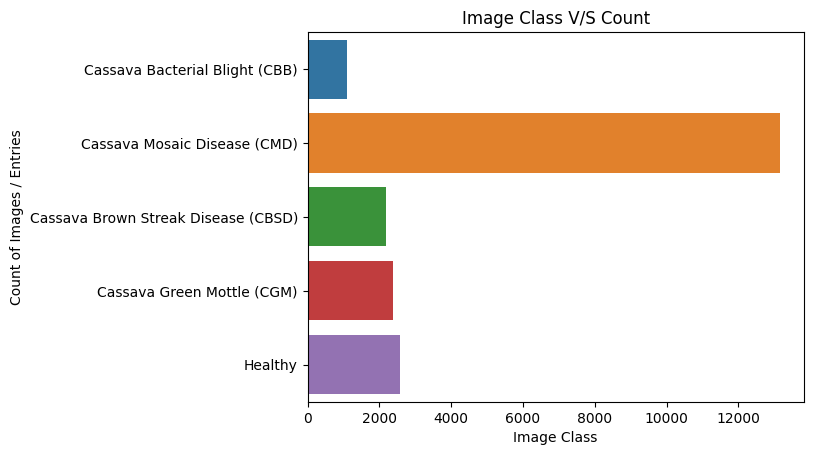

In [14]:
pl = sns.countplot(y="class_name",data=training_df)
pl.set(xlabel ="Image Class", ylabel = "Count of Images / Entries", title ='Image Class V/S Count')

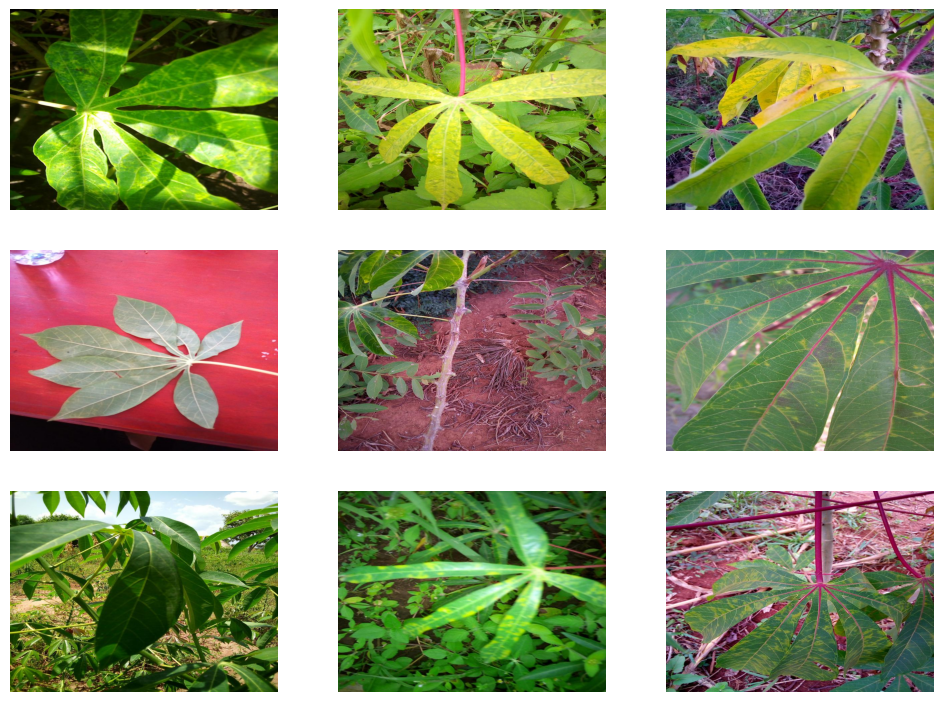

In [15]:
# A snippet which shows us the sample of each class from the train_images while refering the image_id from the training_data.
# Label : Output Class
#  0: 'Cassava Bacterial Blight (CBB)',
#  1: 'Cassava Brown Streak Disease (CBSD)',
#  2: 'Cassava Green Mottle (CGM)',
#  3: 'Cassava Mosaic Disease (CMD)',
#  4: 'Healthy'

sample = training_df[training_df.label == 1].sample(9) # Change rhe label == {} to any integer in the above map to get images from that class.
plt.figure(figsize=(12,12))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(4, 3, ind + 1)
    image = cv2.imread(os.path.join(working_directory + "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

In [16]:
df_new  = training_df # Storing a copy of the dataframe for potentiall future reference.

<center><h2>Logistic Regression Implementation</h2></center>

In [17]:
# Define image size
img_size = (64, 64)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size = img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Load images and labels
print("Images loading..")
X = []
y = []
for idx, row in training_df.iterrows():
    img_path = os.path.join(working_directory, 'train_images', row['image_id'])
    img_array = load_and_preprocess_image(img_path)
    X.append(img_array)
    y.append(row['label'])
print("images loaded...")

print("Creating X and Y...")
X = np.array(X)
y = np.array(y)
print("X and Y created...")

# Flatten the images for logistic regression
X = X.reshape(X.shape[0], -1)

# Split the data
print("splitting...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("splitted...")

Images loading..
images loaded...
Creating X and Y...
X and Y created...
splitting...
splitted...


In [33]:
# Define and train the logistic regression model
print("model creation...")
model = LogisticRegression(n_jobs = -1,max_iter = 150)
print("model created...")
print("fitting...")
model.fit(X_train, y_train)
print("fitted...")

print("evaluating...")
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

model creation...
model created...
fitting...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted...
evaluating...
Accuracy: 0.5018691588785047
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.10      0.13       217
           1       0.21      0.15      0.17       438
           2       0.17      0.14      0.15       477
           3       0.64      0.73      0.68      2632
           4       0.15      0.13      0.14       516

    accuracy                           0.50      4280
   macro avg       0.27      0.25      0.25      4280
weighted avg       0.46      0.50      0.48      4280



<center><h2>CNN implementation using TensorFlow & Keras</h2></center>

In [18]:
Batch_size = 64
img_height, img_width = 256, 256

In [19]:
training_df['label'] = training_df['label'].astype('str') 
                                                # Stores the label integer as a string.(Changes them...) because otherwise we get
                                                # TypeError: If class_mode="categorical", y_col="label" column values must be type string, list or tuple.

In [20]:
# Training images
train_gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
)

train_datagen = train_gen.flow_from_dataframe(
    training_df,
    directory = os.path.join(working_directory, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "training",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 17118 validated image filenames belonging to 5 classes.


In [21]:
# Validation images
val_gen = ImageDataGenerator(
    validation_split = 0.2
)

val_datagen = val_gen.flow_from_dataframe(
    training_df,
    directory = os.path.join(working_directory, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 4279 validated image filenames belonging to 5 classes.


In [22]:
print(f"Size of/Number of images in training set : {len(train_datagen)}\nSize of/Number of images in validation set : {len(val_datagen)}")

Size of/Number of images in training set : 268
Size of/Number of images in validation set : 67


In [23]:
img, label = next(train_datagen)

In [24]:
Steps_per_train = float(train_datagen.n) / train_datagen.batch_size
Steps_per_val = float(val_datagen.n) / val_datagen.batch_size

In [25]:
Steps_per_train, Steps_per_val

(267.46875, 66.859375)

In [26]:
def create_model():
    model = models.Sequential()
    model.add(EfficientNetB3(include_top=False, weights='imagenet',
                             input_shape=(img_height, img_width, 3), drop_connect_rate=0.3))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))
    
    loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
    optimizer = optimizers.Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["categorical_accuracy"])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [27]:
# Build the model
model.build((None))

In [ ]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

In [28]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                            factor=0.2,
                                            mode = "min",
                                            min_lr=1e-6,
                                            patience=2, 
                                            verbose=1)

estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       mode= "min",
                                       patience=3, 
                                       verbose=1,
                                       restore_best_weights=True)

history = model.fit(
    train_datagen,
    steps_per_epoch=int(Steps_per_train),
    epochs=5,
    verbose =1,
    validation_data=val_datagen,
    validation_steps=int(Steps_per_val),
    callbacks=[rlronp, estop]
)

Epoch 1/5


2024-06-15 15:59:56.175591: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[64,144,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,144,131,131]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-15 15:59:57.066464: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.890976406s
Trying algorithm eng3{k11=2} for conv (f32[64,144,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,144,131,131]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-15 15

 75/267 ━━━━━━━━━━━━━━━━━━━━ 1:54 595ms/step - categorical_accuracy: 0.5717 - loss: 1.1479

W0000 00:00:1718467441.312029     604 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6621 - loss: 0.9256

W0000 00:00:1718467566.617780     602 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


267/267 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - categorical_accuracy: 0.6623 - loss: 0.9250 - val_categorical_accuracy: 0.8016 - val_loss: 0.5615 - learning_rate: 1.0000e-04
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - categorical_accuracy: 0.7656 - loss: 0.7141 - val_categorical_accuracy: 0.6909 - val_loss: 0.8079 - learning_rate: 1.0000e-04
Epoch 3/5


W0000 00:00:1718467617.360258     604 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


267/267 ━━━━━━━━━━━━━━━━━━━━ 190s 698ms/step - categorical_accuracy: 0.8152 - loss: 0.5207 - val_categorical_accuracy: 0.8260 - val_loss: 0.5013 - learning_rate: 1.0000e-04
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - categorical_accuracy: 0.7969 - loss: 0.6057 - val_categorical_accuracy: 0.7818 - val_loss: 0.7409 - learning_rate: 1.0000e-04
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 191s 703ms/step - categorical_accuracy: 0.8526 - loss: 0.4147 - val_categorical_accuracy: 0.8369 - val_loss: 0.4798 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


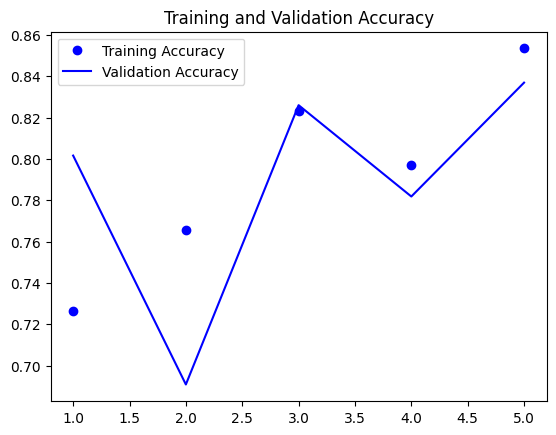

In [29]:
train_acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

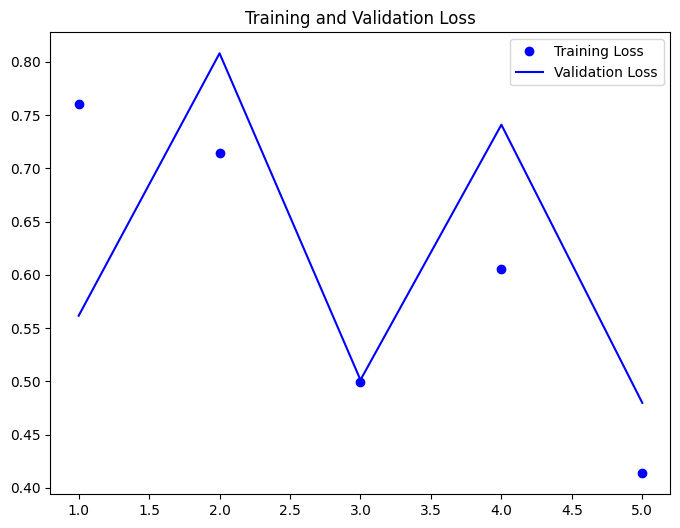

In [30]:
plt.figure(figsize=(8,6))
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

***Reference :  <br>https://www.kaggle.com/code/muhammadibrahimqasmi/cracking-cassava-cnns-in-disease-detection#-Load--Dataset-
<br>https://www.kaggle.com/code/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn/notebook
<br>https://www.youtube.com/watch?v=R7fKjr4gtSc
<br>https://www.kaggle.com/code/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn/notebook#Visualization-of-CNN-intermediate-activations
<br>https://github.com/aswintechguy/Deep-Learning-Projects/blob/main/Cassava%20Leaf%20Disease%20Detection%20-%20Pytorch%20Image%20Classification/Cassava%20Leaf%20Disease%20Detection%20-%20Pytorch%20Tutorial.ipynb***